Net:  net1
Path:  0
[(0, 2, 3), (0, 3, 3), (0, 4, 3), (0, 5, 3), (0, 6, 3), (0, 7, 3), (0, 8, 3), (0, 8, 4), (0, 8, 5), (0, 8, 6), (0, 8, 7), (0, 8, 8), (0, 8, 9)]
Path:  1
[(0, 5, 3), (0, 5, 4), (0, 5, 5), (0, 5, 6), (1, 5, 6)]
Net:  net2
Path:  0
[(0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 2, 4), (0, 3, 4), (0, 4, 4)]
Path:  1
[(0, 4, 4), (1, 4, 4), (1, 5, 4), (1, 6, 4), (1, 6, 5), (1, 6, 6)]
Net:  net3
Path:  0
[(1, 9, 9), (1, 8, 9), (1, 7, 9), (1, 6, 9), (1, 5, 9), (1, 4, 9), (1, 3, 9), (1, 2, 9), (1, 1, 9), (1, 0, 9), (1, 0, 8), (1, 0, 7), (1, 0, 6), (1, 0, 5), (0, 0, 5)]
Path:  1
[(0, 0, 5), (0, 0, 4), (0, 0, 3), (0, 0, 2), (0, 0, 1), (0, 0, 0), (0, 1, 0), (0, 2, 0)]


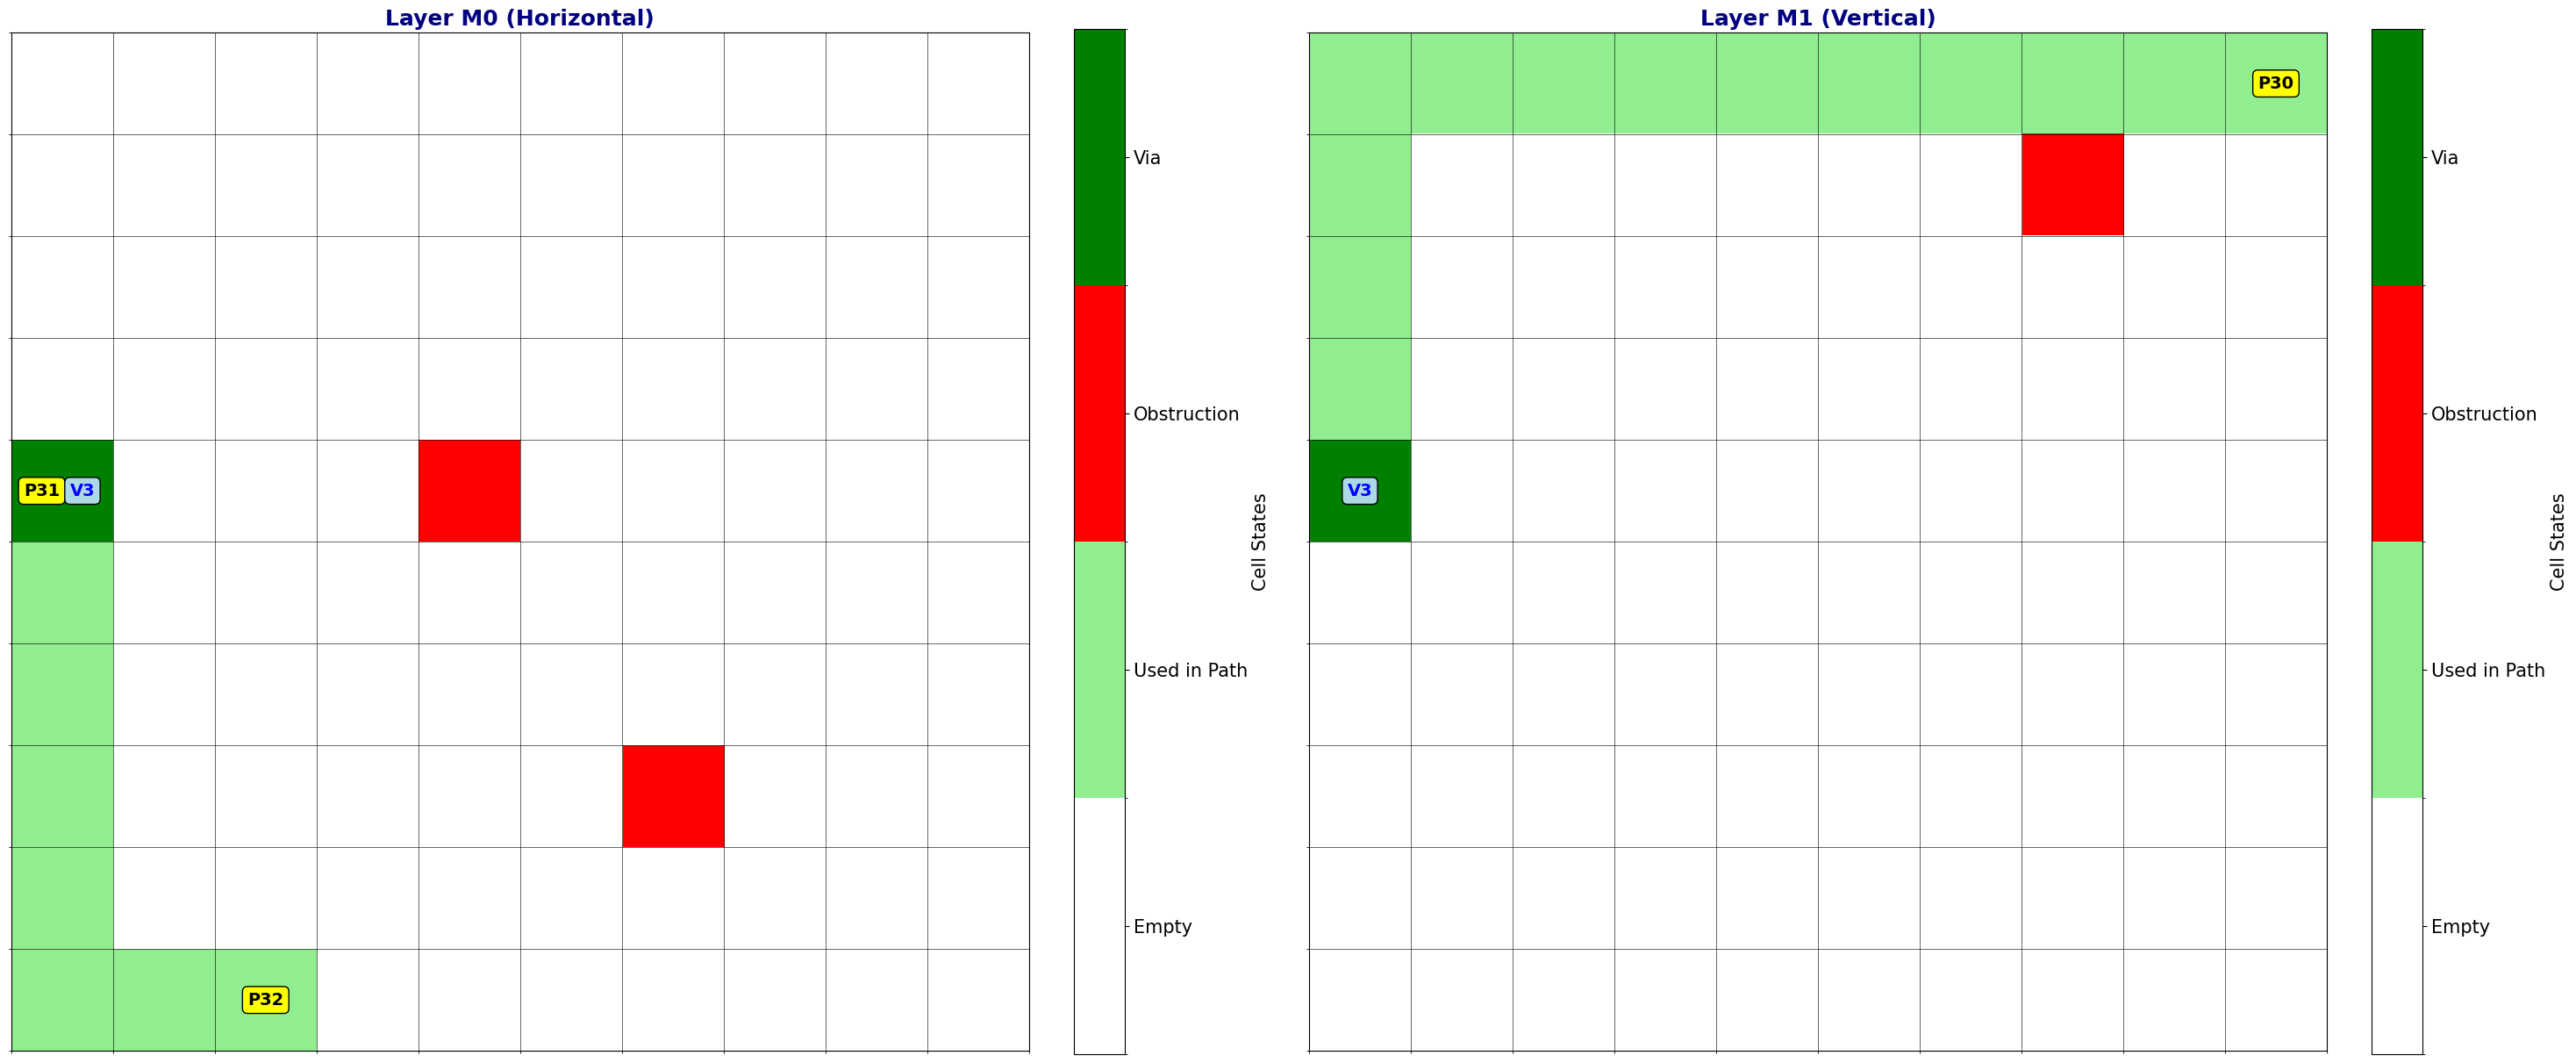

In [115]:
# Global grid representation
import re
import matplotlib.pyplot as plt
import numpy as np
import heapq
from collections import deque
from matplotlib.colors import ListedColormap, BoundaryNorm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Global variables
grid_dimensions = None
bend_penalty = None
via_penalty = None
obstructions = []
nets = {}
grid = []
num_vias = 0

# Function to parse the input file
def parse_input_file(file_path):
    global grid_dimensions, bend_penalty, via_penalty, obstructions, nets, num_vias

    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Parse the grid dimensions and penalties
    grid_info = list(map(int, lines[0].strip().split(',')))
    grid_dimensions = (grid_info[0], grid_info[1])  # NxM grid
    bend_penalty = grid_info[2]
    via_penalty = grid_info[3]

    # Parse the obstructions
    for line in lines[1:]:
        if line.startswith("OBS"):
            match = re.search(r"\((\d+),\s*(\d+),\s*(\d+)\)", line)
            if match:
                obstructions.append((int(match.group(1)), int(match.group(2)), int(match.group(3))))

    # Parse the nets
    for line in lines[1:]:
        if line.startswith("net"):
            net_name = line.split(' ')[0]
            net_points = re.findall(r"\((\d+),\s*(\d+),\s*(\d+)\)", line)
            nets[net_name] = [(int(layer), int(x), int(y)) for layer, x, y in net_points]
def initialize_grid():
    global grid, grid_dimensions, obstructions, nets, num_vias

    # Extract dimensions
    rows, cols = grid_dimensions

    # Create a 3D list for two layers, each initialized with default cost (0 for simplicity)
    grid = [[[{'cost': 1, 'obstruction': False, 'used_in_path': False, 'pin': False, 'via': False, 'via_num': 0, 'net_num': -1, 'pin_num': -1, 'path_num': -1} for _ in range(cols)] for _ in range(rows)] for _ in range(2)]

    # Mark obstructions
    for layer, x, y in obstructions:
        grid[layer][x][y]['obstruction'] = True
        grid[layer][x][y]['cost'] = float('inf')  # Assign a high cost to obstructions
    net_num = 1  # Start with net number 0
    pin_num = 0  # Start with pin number 0
    for net in nets:
        for layer, x, y in nets[net]:
            grid[layer][x][y]['pin'] = True
            grid[layer][x][y]['pin_num'] = pin_num  # Assign the current pin number to the cell
            grid[layer][x][y]['net_num'] = net_num  # Assign the current net number to the cell
            pin_num += 1  # Increment pin number for the next pin
        pin_num = 0  # Reset pin number for the next net
        net_num += 1  # Increment net number for the next net




def visualize_3d_grid_matplotlib(net=None, path=None):
    global grid, grid_dimensions, num_vias

    # Extract grid dimensions
    rows, cols = grid_dimensions

    # Prepare two grid matrices for the layers
    grid_matrix_layer0 = np.zeros((cols, rows), dtype=int)
    grid_matrix_layer1 = np.zeros((cols, rows), dtype=int)

    for layer in range(2):
        for row in range(rows):
            for col in range(cols):
                cell = grid[layer][row][col]

                if cell['used_in_path']:
                    if layer == 0:
                        grid_matrix_layer0[col][row] = 1
                    else:
                        grid_matrix_layer1[col][row] = 1
                else:
                    if layer == 0:
                        grid_matrix_layer0[col][row] = 0
                    else:
                        grid_matrix_layer1[col][row] = 0
                if cell['via']:
                    if layer == 0:
                        grid_matrix_layer0[col][row] = 3
                    else:
                        grid_matrix_layer1[col][row] = 3
                if path:
                    if cell['path_num'] != path:
                        if layer == 0:
                            grid_matrix_layer0[col][row] = 0
                        else:
                            grid_matrix_layer1[col][row] = 0
                if net:
                    if cell['net_num'] != net:
                        if layer == 0:
                            grid_matrix_layer0[col][row] = 0
                        else:
                            grid_matrix_layer1[col][row] = 0
                if cell['obstruction']:
                    if layer == 0:
                        grid_matrix_layer0[col][row] = 2
                    else:
                        grid_matrix_layer1[col][row] = 2

    # Create a side-by-side visualization of the two layers
    fig, axes = plt.subplots(1, 2, figsize=(30, 15))  # One subplot for each layer

    # Define custom values and colors for the layers
    values = [0, 1, 2, 3]  # The values you want to map to specific colors (0=empty, 1=used_in_path, 2=obstruction)
    colors = ['white', 'lightgreen', 'red', 'green']  # Colors for each value (0=white, 1=green, 2=red)
        
    # Create a ListedColormap and BoundaryNorm for the specific values
    cmap = ListedColormap(colors)
    norm = BoundaryNorm([0, 1, 2, 3, 4], len(values))  # Normalizing over a range from 0 to 3 to cover [0, 1, 2]

    # Plot Layer 0 with the custom colormap and norm
    im0 = axes[0].imshow(grid_matrix_layer0, cmap=cmap, norm=norm, origin='lower')
    axes[0].set_title("Layer M0 (Horizontal)", fontsize=18, fontweight='bold', color='navy', loc='center')  # Enhanced title styling
    axes[0].set_xticks(np.arange(-0.5, cols, 1), minor=True)
    axes[0].set_yticks(np.arange(-0.5, rows, 1), minor=True)
    axes[0].grid(which="minor", color="black", linestyle='-', linewidth=0.6, alpha=0.7)  # Slightly thicker grid lines
    axes[0].set_aspect('equal')
    axes[0].set_xticks([])  # Remove x-ticks
    axes[0].set_yticks([])  # Remove y-ticks

    # Add 'P' and 'V' annotations for Layer 0
    for row in range(rows):
        for col in range(cols):
            cell = grid[0][col][row]  # Access the cell in Layer 0
            if path:
                if cell['path_num'] != path:
                    continue
            if net:
                if cell['net_num'] != net:
                    continue
            via_number = cell.get('via_num', '')  # Get the via number from the cell
            pin_number = cell.get('pin_num', '')  # Get the pin number from the cell
            net_number = cell.get('net_num', '')  # Get the net number from the cell
            # Check for conditions and annotate accordingly
            if cell.get('pin', False) and cell.get('via', False):  # Both pin and via
                via_number = cell.get('via_num', '')  # Get the via number from the cell
                
                # Annotate 'P' and 'V' separately but side by side with more space
                # Position the 'P' annotation in the left part of the cell
                axes[0].text(col-0.2, row, f'P{net_number}{pin_number}', color='black', ha='center', va='center', 
                            fontsize=14, fontweight='bold', backgroundcolor='white', 
                            bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.3'))
                
                # Position the 'V' annotation in the right part of the cell
                axes[0].text(col+0.2, row, f'V{via_number}', color='blue', ha='center', va='center', 
                            fontsize=14, fontweight='bold', backgroundcolor='white', 
                            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.3'))
                    
            elif cell.get('pin', False):  # Only pin
                axes[0].text(col, row, f'P{net_number}{pin_number}', color='black', ha='center', va='center', 
                            fontsize=14, fontweight='bold', backgroundcolor='white', 
                            bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.3'))
            elif cell.get('via', False):  # Only via
                via_number = cell.get('via_num', '')  # Get the via number from the cell
                axes[0].text(col, row, f"V{via_number}", color='blue', ha='center', va='center', 
                            fontsize=14, fontweight='bold', backgroundcolor='white', 
                            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.3'))

    # Add colorbar to the first plot to show what the colors represent
    cbar = fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    cbar.set_ticks([0.5, 1.5, 2.5, 3.5])
    cbar.set_ticklabels(['Empty', 'Used in Path', 'Obstruction', 'Via'], fontsize=15)
    cbar.set_label('Cell States', fontsize=15)

    # Now, plot Layer 1 with similar enhancements
    im1 = axes[1].imshow(grid_matrix_layer1, cmap=cmap, norm=norm, origin='lower')
    axes[1].set_title("Layer M1 (Vertical)", fontsize=18, fontweight='bold', color='navy', loc='center')  # Enhanced title styling
    axes[1].set_xticks(np.arange(-0.5, cols, 1), minor=True)
    axes[1].set_yticks(np.arange(-0.5, rows, 1), minor=True)
    axes[1].grid(which="minor", color="black", linestyle='-', linewidth=0.6, alpha=0.7)  # Slightly thicker grid lines
    axes[1].set_aspect('equal')
    axes[1].set_xticks([])  # Remove x-ticks
    axes[1].set_yticks([])  # Remove y-ticks
    
    # Add 'P' and 'V' annotations for Layer 1
    for row in range(rows):
        for col in range(cols):
            cell = grid[1][col][row]  # Access the cell in Layer 1
            if path:
                if cell['path_num'] != path:
                    continue
            if net:
                if cell['net_num'] != net:
                    continue
            via_number = cell.get('via_num', '')  # Get the via number from the cell
            pin_number = cell.get('pin_num', '')  # Get the pin number from the cell
            net_number = cell.get('net_num', '')  # Get the net number from the cell
            # Check for conditions and annotate accordingly
            if cell.get('pin', False) and cell.get('via', False):  # Both pin and via

                
                # Annotate 'P' and 'V' separately but side by side with more space
                # Position the 'P' annotation in the left part of the cell
                axes[1].text(col-0.2, row, f'P{net_number}{pin_number}', color='black', ha='center', va='center', 
                            fontsize=14, fontweight='bold', backgroundcolor='white', 
                            bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.3'))
                
                # Position the 'V' annotation in the right part of the cell
                axes[1].text(col+0.2, row, f'V{via_number}', color='blue', ha='center', va='center', 
                            fontsize=14, fontweight='bold', backgroundcolor='white', 
                            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.3'))
                    
            elif cell.get('pin', False):  # Only pin
                axes[1].text(col, row, f'P{net_number}{pin_number}', color='black', ha='center', va='center', 
                            fontsize=14, fontweight='bold', backgroundcolor='white', 
                            bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.3'))
            elif cell.get('via', False):  # Only via
                via_number = cell.get('via_num', '')  # Get the via number from the cell
                axes[1].text(col, row, f"V{via_number}", color='blue', ha='center', va='center', 
                            fontsize=14, fontweight='bold', backgroundcolor='white', 
                            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.3'))

    # Add colorbar to the second plot to show what the colors represent
    cbar1 = fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    cbar1.set_ticks([0.5, 1.5, 2.5, 3.5])
    cbar1.set_ticklabels(['Empty', 'Used in Path', 'Obstruction', 'Via'], fontsize=15) 
    cbar1.set_label('Cell States', fontsize=15)

    # Adjust layout to ensure titles and labels don't overlap
    fig.tight_layout(pad=3)

    plt.show()


def order_nets_by_pins(nets):
    # Sort nets by the number of pins (ascending order)
    return sorted(nets.items(), key=lambda x: len(x[1]))

import heapq

def find_path(grid, sources, targets, bend_penalty, via_penalty):
    global num_vias
    rows = len(grid[0])
    cols = len(grid[0][0])

    # Directions for neighbors: (layer, dx, dy)
    directions = {
        0: [(0, 0, 1), (0, 0, -1), (0, 1, 0), (0, -1, 0), (1, 0, 0), (-1, 0, 0)],  # Horizontal layer
        1: [(0, 0, 1), (0, 0, -1), (0, 1, 0), (0, -1, 0), (1, 0, 0), (-1, 0, 0)]   # Vertical layer
    }
    
    # Preferred directions for each layer
    preferred = {
        0: (0, 1),  # Horizontal: (dx, dy)
        1: (1, 0)   # Vertical: (dx, dy)
    }

    # Priority queue: (cost, (layer, x, y), previous_direction)
    pq = []
    dist = {}
    for source in sources:
        heapq.heappush(pq, (0, source, None))  # Each source starts with a cost of 0
        dist[source] = 0  # Cost to reach source is 0

    # Parent dictionary to reconstruct the path
    parent = {}
    target_set = set(targets)
    while pq:
        # Pop the cell with the smallest cost
        current_cost, (layer, x, y), prev_direction = heapq.heappop(pq)

        # Stop if we reach the target
        if (layer, x, y) in target_set:
            # Reconstruct the path from the parent dictionary
            path = []
            current = (layer, x, y)
            while current in parent:
                path.append(current)
                grid[current[0]][current[1]][current[2]]['used_in_path'] = True
                
                # Check for layer transitions (vias)
                previous = parent[current]
                if current[0] != previous[0]:  # If the layer changes
                    grid[current[0]][current[1]][current[2]]['via'] = True  # Mark the cell as a via
                    num_vias += 1
                    grid[current[0]][current[1]][current[2]]['via_num'] = num_vias  # Assign a via number
                    grid[previous[0]][previous[1]][previous[2]]['via'] = True  # Mark the previous cell as a via
                    grid[previous[0]][previous[1]][previous[2]]['via_num'] = num_vias  # Assign the same via number
                
                current = previous
            
            # Append the last cell in the path (source or last step)
            path.append(current)
            grid[current[0]][current[1]][current[2]]['used_in_path'] = True
            
            # Handle the last cell (target) for via marking
            last_cell = (layer, x, y)
            if parent.get(last_cell) and last_cell[0] != parent[last_cell][0]:  # If target has a layer transition
                grid[last_cell[0]][last_cell[1]][last_cell[2]]['via'] = True
            else:
                grid[last_cell[0]][last_cell[1]][last_cell[2]]['via'] = False  # No transition at the last cell

            return (path[::-1], last_cell)  # Reverse the path to get source to target

        # Skip if this state has already been processed with a smaller cost
        if (layer, x, y) in dist and current_cost > dist[(layer, x, y)]:
            continue
        # Explore neighbors
        for dlayer, dx, dy in directions[layer]:
            nx, ny = x + dx, y + dy
            nlayer = layer + dlayer

            # Check boundaries and obstructions
            if 0 <= nx < rows and 0 <= ny < cols and 0 <= nlayer < 2 and not grid[nlayer][nx][ny]['obstruction'] and not grid[nlayer][nx][ny]['used_in_path']:

                # Calculate the cost to move to the neighbor
                move_cost = grid[nlayer][nx][ny]['cost']
                new_cost = current_cost + move_cost

                # Add bend penalty if direction changes from preferred direction
                if prev_direction is not None:
                    preferred_dx, preferred_dy = preferred[layer]
                    if (dx, dy) != prev_direction and (dx, dy) != (preferred_dx, preferred_dy):
                        new_cost += bend_penalty

                # Add via penalty if transitioning layers
                if dlayer != 0:
                    new_cost += via_penalty

                # Update distance and add to priority queue if this path is better
                if (nlayer, nx, ny) not in dist or new_cost < dist[(nlayer, nx, ny)]:
                    dist[(nlayer, nx, ny)] = new_cost
                    parent[(nlayer, nx, ny)] = (layer, x, y)
                    heapq.heappush(pq, (new_cost, (nlayer, nx, ny), (dx, dy)))

    # If we reach here, the target is unreachable
    return ([], None)


def route_nets(grid, nets, bend_penalty, via_penalty):
    # Order nets by heuristic
    ordered_nets = order_nets_by_pins(nets)

    # Store results
    net_paths = {}
    path_num = 0
    net_num = 1
    for net_name, pins in ordered_nets:
        paths = []
        #TODO: implement a heuristic to choose the first source we should begin with
        pins_covered_map = {pin: False for pin in pins}
        pins_covered_map[pins[0]] = True
        unreached_targets = [key for key, value in list(pins_covered_map.items())[1:] if not value]
        sources = set([pins[0]])
        
        while not all(pins_covered_map.values()):
            # Route between pins using Lee's Algorithm
            path, target = find_path(grid, list(sources), unreached_targets, bend_penalty, via_penalty)
            unreached_targets.remove(target)
            paths.append(path)
            for cell in path:
                grid[cell[0]][cell[1]][cell[2]]['path_num'] = path_num
                grid[cell[0]][cell[1]][cell[2]]['net_num'] = net_num
            path_num += 1
            pins_covered_map[target] = True

            sources = set(list(sources) + path)
        net_num += 1


        # Store the path for the net    
        net_paths[net_name] = paths


    return net_paths


if __name__ == "__main__":
    input_file = "input.txt"  # Replace with your input file path
    parse_input_file(input_file)  # Parse the input file
    initialize_grid()  # Initialize the 3D grid
    # Route the nets
    routed_nets = route_nets(grid, nets, bend_penalty, via_penalty)

    # Print the routed paths
    for net_name, paths in routed_nets.items():
        print("Net: ", net_name)
        for i, path in enumerate(paths):
            print("Path: ", i)
            print(path)
            
    visualize_3d_grid_matplotlib(net=3)
